In [144]:
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error as mse

In [2]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
GSPC = data.DataReader('^GSPC', 'yahoo', '2007-01-01', '2011-01-01')

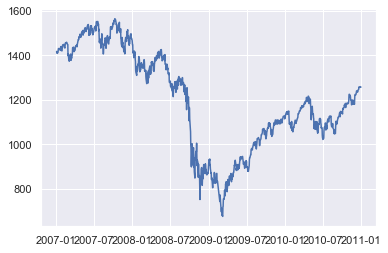

In [8]:
plt.plot(GSPC['Adj Close'])

We will try to implement the procedure in Bruder, Dao, and Roncalli, but sklearn exists so we will try to use that.

The assumption is that within each window $t\in[0, T]$ there is a time series such that $y_t = x_t + \epsilon_t$ where $x_t$ is the trend process and $\epsilon_t$ is the noies process. Under an $L_1$ filter the objective function becomes:$$\frac 1 2 \sum_{t=1}^n(y_t - x_t)^2 + \lambda \sum_{t=2}^{n-1}|x_{t-1}-2x_t + x_{t+1}|$$
Then we want to minimize this under an optimal $\lambda$ for a given time window of size T. Bruder et al find that $\lambda_{max} \propto T^{5/2}$, but since sklearn exisets it should be able to calibrate for $\lambda$ without necessarily using their procedure.  

In [59]:
lGSPC = GSPC['Adj Close']

We start simple: Assume there's an affine form, use the lasso regression on the time series split into 2 equal bins.

In [80]:
halfway = int(lGSPC.shape[0]/2)
X = np.arange(1,halfway+1,1).reshape(-1,1)
X2 = X + halfway
lGSPC1 = lGSPC[0:halfway]
lGSPC2 = lGSPC[halfway:]
lasso1 = lm.Lasso(alpha = 1500).fit(X, lGSPC1)
lasso2 = lm.Lasso(alpha = 1500).fit(X2, lGSPC2)

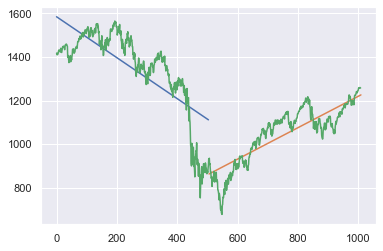

In [82]:
plt.plot(lasso1.predict(X))
plt.plot(X2, lasso2.predict(X2))
plt.plot(lGSPC.values)

For some reason, unlike th epaper, we are unable to impose continuity even though we really should but then again all we care about is the trend.

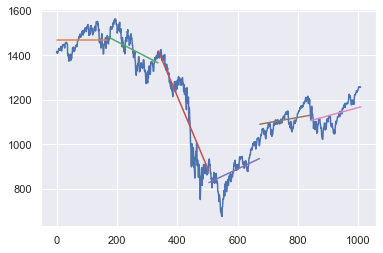

In [223]:
bins = 6
splitpoint0 = int(lGSPC.shape[0])/bins
X0 = np.arange(1, splitpoint0+1,1).reshape(-1,1)
Xs = []
lassos = []
alpha = 75
for i in range(bins):
    X = X0  + i*splitpoint0
    Xs.append(X)
    lGSPClocal = lGSPC[int(i*splitpoint0):int((1+i)*splitpoint0)]
    lassos.append(lm.Lasso(alpha = 1500).fit(X, lGSPClocal))

plt.plot(lGSPC.values)
for i, obj in enumerate(Xs):
    plt.plot(obj, lassos[i].predict(obj))

In [224]:
for l in lassos:
    print("slope:",l.coef_[0])

slope: 0.0
slope: -0.7049050808891779
slope: -3.2249055009810705
slope: 0.6454311013266996
slope: 0.2420882278527265
slope: 0.3716468822427442


A cross validation algorithm given is:  
For a given $T_1, T_2$:
- Divide historical data into m rolling test sets T_2^i (i = 1 ... m)
- For each test window T_2^i compute the statistic $\lambda_{max}^i$
- From all $\lambda_{max}^i$ compute the average and standard deviation.
- Compute boundaries $\lambda_1 = \bar{\lambda} - 2\sigma_\lambda$, $\lambda_2 = \bar{\lambda} + 2\sigma_\lambda$
- For j = 1 to j = n:
 - Let $\lambda_j = \lambda_1 (\frac{\lambda_2}{\lambda_1})^{j/n}$
 - Divide the historical data into p rolling tradining sets T_1^k (k = 1, ... p)
 - For k = 1 to k = p:
   - Run L_1 filter on each T_1^k
   - Forecast trend for adjacent test window T_2^k
   - Compute error for that $\lambda$ on the test window $e^k(\lambda_j)$
 - Compute total error $e(\lambda_j) = \sum_{k=1}^m e^k(\lambda_j)$
-Minimize total error to find optimal $\lambda^*$
-Run the $L_1$ filter with $\lambda = \lambda^*$

Since we are using lasso to denoise, I assume x is just a simple linear series of 0 to T.

Parameters from the paper:

In [121]:
m = 12
p = m
n = 15

T1 = 400
T2 = 50
interval = (lGSPC.shape[0]-450)/(m-1)
interval

50.72727272727273

We will attempt to duplicate those results using 12 rolling test windows of 50, 12 training windows of 400.

In [133]:
testsets = []
trainsets = []
xtest = np.arange(1,T2+1,1).reshape(-1,1)
for i in range(m):
    testsets.append(lGSPC[int(interval*i+T1):
                          int(interval*i+T1+T2)])
    trainsets.append(lGSPC[int(interval*i):
                          int(interval*i + T1)])

In [218]:
lmaxes = []
for tset in testsets:
    lmax = lm.LassoLarsCV(cv = 5).fit(xtest, tset).alpha_
    lmaxes.append(lmax)
    print(lmax)
    

0.0
0.0
0.0
0.0
3.266755479450674
0.0
0.0
2.4903214382594
4.748300237463814
2.0104628934398256
0.0
0.0


In [219]:
lbar = np.mean(lmaxes)
std = np.std(lmaxes)
l1 = lbar-2*std
l2 = lbar+2*std
#condition to force l1 > 0 but infintesimal:
if l1 < 0: l1 = 1e-3

In [220]:
xtrain = np.arange(1,T1+1,1 ).reshape(-1,1)
xtestpred = np.arange(T1+1, T1+T2+1,1).reshape(-1,1)
errors = []
for j in range(1,n+1):
    lj = l1*(l2/l1)**(j/n)
#     print(lj)
    totalerror = 0
    for i, trainset in enumerate(trainsets):
        results = lm.Lasso(alpha = lj).fit(xtrain, trainset).predict(xtestpred)
        totalerror += mse(results, testsets[i])
    errors.append((lj, totalerror))

In [221]:
errors = np.array(errors)
print(errors)

[[1.74475055e-03 5.44355730e+05]
 [3.04415447e-03 5.44355701e+05]
 [5.31129018e-03 5.44355649e+05]
 [9.26687644e-03 5.44355560e+05]
 [1.61683877e-02 5.44355404e+05]
 [2.82098033e-02 5.44355132e+05]
 [4.92190698e-02 5.44354656e+05]
 [8.58749989e-02 5.44353827e+05]
 [1.49830451e-01 5.44352381e+05]
 [2.61416762e-01 5.44349858e+05]
 [4.56107038e-01 5.44345455e+05]
 [7.95793004e-01 5.44337775e+05]
 [1.38846028e+00 5.44324376e+05]
 [2.42251683e+00 5.44301003e+05]
 [4.22668756e+00 5.44260242e+05]]


In [200]:
np.where(errors == np.amin(errors,0))

(array([ 0, 14], dtype=int64), array([0, 1], dtype=int64))

In [201]:
np.amin(errors, 0)

array([1.74475055e-03, 5.44260242e+05])

In [212]:
rowcoord = np.where(errors == np.amin(errors,0)[1])[0][0]
rowcoord

14

4.226687560972864

0.5258436672093888
-1.3408856552175032
-3.8608860753093963
1.281411675655025
0.8780688021810518
1.0076274565710694


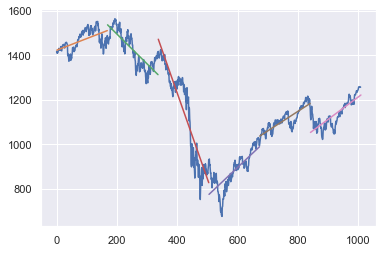

In [225]:
bins = 6
splitpoint0 = int(lGSPC.shape[0])/bins
X0 = np.arange(1, splitpoint0+1,1).reshape(-1,1)
Xs = []
lassos = []
alpha = errors[rowcoord,0]
for i in range(bins):
    X = X0  + i*splitpoint0
    Xs.append(X)
    lGSPClocal = lGSPC[int(i*splitpoint0):int((1+i)*splitpoint0)]
    lassos.append(lm.Lasso(alpha = alpha).fit(X, lGSPClocal))

plt.plot(lGSPC.values)
for i, obj in enumerate(Xs):
    plt.plot(obj, lassos[i].predict(obj))
    print(lassos[i].coef_[0])